# Please set up the working directory and output directory!

## Setup and imports

In [1]:
%matplotlib inline

import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

import os
import itertools
import numpy as np
import pandas as pd
from scipy import stats

sns.set_style('whitegrid')
sns.set_palette('colorblind')
 
plt.rcParams['figure.titlesize'] = 18
plt.rcParams['axes.titlesize'] = 16
plt.rcParams['axes.labelsize'] = 14
plt.rcParams['xtick.labelsize'] = 14
plt.rcParams['ytick.labelsize'] = 14
plt.rcParams['legend.fontsize'] = 14
plt.rcParams['pdf.fonttype'] = 42
plt.rcParams['ps.fonttype'] = 42

MARKERS = 'o v ^ < > s p P * x X D d'.split()

# Please set OUTDIR and WORKDIR here

In [2]:
import os
print(f'You are at: {os.path.abspath(os.path.join(os.getcwd(), ".."))}')

You are at: /mnt/dv/wid/projects5/Roy-singlecell/jiaxin_work/scRNAseq_NetInference


# Please fill in WORKDIR as the root path to your downloaded repo

In [3]:
WORKDIR = '/mnt/dv/wid/projects5/Roy-singlecell/jiaxin_work/scRNAseq_NetInference/' # This is the path on our server, you should change it!
os.chdir(WORKDIR)
OUTDIR = './Figures'
if not os.path.exists(OUTDIR):
    os.mkdir(OUTDIR)

In [5]:
import yaml
# config = yaml.load(open('/mnt/dv/wid/projects5/Roy-singlecell/scRNAseq_NetInference/snakefiles/04_evaluation/fscore.yaml'),
#                    Loader=yaml.FullLoader)

# #ALGORITHMS = config['algorithms']
# #DATASETS = config['dataset_order']
# #ALG_FIX = config['algorithm_namefix']
ALGORITHMS = ['Pearson', 'SCENIC', 'MERLIN','PIDC', 'LEAP', 'SCODE','Scribe', 'SILGGM', 'Inferelator', 'kNN-DREMI']

# ALGORITHMS = sorted(config['algorithms'], key=lambda s: s.lower())
# ALGORITHMS = [a for a in ALGORITHMS if a not in ['pearson', 'random']] + ['pearson']


DATASETS = [
    'gasch_GSE102475',
    'jackson_GSE125162',
    'sridharan_A2S',
    'sridharan_FBS',
    'zhao_GSE114952',
    'shalek_GSE48968',
    'han_GSE107552'
]

ALG_FIX = {
    'inferelator': 'Inferelator',
    'knnDREMI': 'kNN-DREMI',
    'pearson': 'Pearson',
    'random': 'Random'
}
#METRICS = config['metrics']

METRICS = [
    'fscore',
    'AUPR',
    'n_TFs',
    'precision'
]
PRIMARY_GS = ['Perturb', 'ChIP', 'Both']

# Our 10 included algorithms get the seaborn colorblind palette
# and random gets dark grey
ALG_PALETTE = sns.color_palette('colorblind') + [sns.xkcd_rgb['dark grey']]
PALETTE_MAP = {a: c for a, c in zip(ALGORITHMS, ALG_PALETTE)}

In [6]:
# Grouped by species
DATASETS = [
    'gasch_GSE102475',
    'jackson_GSE125162',
    'sridharan_A2S',
    'sridharan_FBS',
    'zhao_GSE114952',
    'shalek_GSE48968',
    'han_GSE107552'
]
alg_fix = {
    'inferelator': 'Inferelator',
    'knnDREMI': 'kNN-DREMI',
    'pearson': 'Pearson',
    'random': 'Random'
}

ALGORITHMS = [alg_fix.get(a, a) for a in ALGORITHMS]


In [7]:
ALG_FIX = {
    'inferelator': 'Inferelator',
    'knnDREMI': 'kNN-DREMI',
    'pearson': 'Pearson',
    'random': 'Random'
}

In [8]:
METRICS = [
    'fscore',
    'AUPR',
    'n_TFs',
    'precision'
]
PRIMARY_GS = ['Perturb', 'ChIP', 'Both']
ALG_PALETTE = sns.color_palette('colorblind') + [sns.xkcd_rgb['dark grey']]
PALETTE_MAP = {a: c for a, c in zip(ALGORITHMS, ALG_PALETTE)}

## Load benchmarking data

In [9]:
dfs = []    
for alg in ALGORITHMS:
    if alg == 'Random':
        continue

    df = pd.read_table(os.path.join(WORKDIR,'results/benchmark/{alg}/resource_usage.txt'.format(alg=alg)))
    dfs.append(df)
    
resources = pd.concat(dfs).reset_index(drop=True)
resources = resources.loc[resources.n_genes > 0]
resources.algorithm = resources.algorithm.replace(ALG_FIX)

## Compute aggregate ranks

Runtime and memory ranks

In [10]:
resources

,algorithm,n_genes,time,mem
0,Pearson,10,1.29,77992
1,Pearson,25,0.80,82252
2,Pearson,50,0.84,83376
3,Pearson,100,1.18,95648
4,Pearson,250,4.39,102352
...,...,...,...,...
93,kNN-DREMI,500,3650.45,143496
94,kNN-DREMI,1000,13523.51,199460
95,kNN-DREMI,2000,43571.48,354788
96,kNN-DREMI,5000,256014.24,1029180


In [11]:
# Compute ranks wrt largest benchmark set (8k genes)
benchmark_ranks = pd.melt(resources.loc[(resources.n_genes == 8000) |
                                        ((resources.algorithm == 'Scribe') & (resources.n_genes == 2000))],
                          id_vars=['algorithm'],
                          value_vars=['time', 'mem'],
                          var_name='metric',
                          value_name='score')

# Scribe didn't complete on full gene benchmark
benchmark_ranks.loc[(benchmark_ranks.algorithm == 'Scribe') & (benchmark_ranks.metric == 'mem'), 'score'] = np.nan

# Rank algorithm performance wrt runtime and memory
benchmark_ranks['rank'] = benchmark_ranks.groupby(['metric'])['score']\
                                         .rank(ascending=True, method='average')

# Re-organize for heatmap
benchmark_ranks = benchmark_ranks.pivot_table(columns='algorithm', index='metric', values='rank')
benchmark_ranks = benchmark_ranks.loc[['time', 'mem'], ALGORITHMS]

Network accuracy ranks

In [12]:
benchmark_ranks

algorithm,Pearson,SCENIC,MERLIN,PIDC,LEAP,SCODE,Scribe,SILGGM,Inferelator,kNN-DREMI
metric,,,,,,,,,,
time,4.0,1.0,7.0,9.0,6.0,2.0,10.0,3.0,5.0,8.0
mem,4.0,3.0,6.0,8.0,5.0,1.0,NaN,7.0,9.0,2.0


Order algorithms based on median rank across 5 columns (runtime, memory, median F-score/AUPR/predTFs)

In [13]:
order = pd.concat([benchmark_ranks]).T.median(axis=1).sort_values(ascending=True).index
benchmark_ranks = benchmark_ranks.loc[:, order]

In [14]:
order

Index(['SCODE', 'SCENIC', 'Pearson', 'SILGGM', 'kNN-DREMI', 'LEAP', 'MERLIN',
       'Inferelator', 'PIDC', 'Scribe'],
      dtype='object', name='algorithm')

## Fig 2B

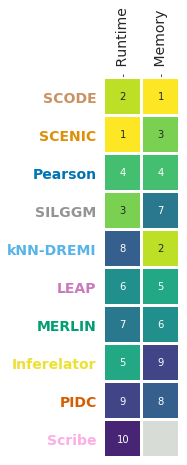

In [15]:
fig, axes = plt.subplots(1, 1, figsize=(6, 7))

ax = axes
ax = sns.heatmap(benchmark_ranks.T, ax=ax,
                 annot=True, fmt='.0f',
                 vmin=1, vmax=11,
                 cbar=False, mask=benchmark_ranks.T.isnull(),
                 cmap='viridis_r', square=True,
                 linewidths=2)

    
# Set algorithm labels
ax.set_yticklabels(ax.get_yticklabels(), rotation=0, ha='right')
[t.set_color(PALETTE_MAP[alg]) for alg, t in zip(order, ax.yaxis.get_ticklabels())]
[t.set_fontweight('bold') for t in ax.yaxis.get_ticklabels()]

# ax.set_xticklabels([])
ax.xaxis.tick_top()
ax.set_xticklabels([' Runtime', ' Memory'], rotation=90, ha='center', va='bottom')
ax.set_xlabel(None)
ax.set_ylabel(None)
ax.set_facecolor(sns.xkcd_rgb['light grey'])


# fig.suptitle('Median rank across datasets')

#plt.subplots_adjust(wspace=-0.5)

plt.savefig(os.path.join(OUTDIR, 'fig2a_overall_ranks.pdf'), bbox_inches='tight')

## Fig 2A

In [18]:
resources['time_hours'] = resources['time'] / 3600
resources['log_hours'] = np.log10(resources['time_hours'])
resources['mem_GB'] = resources['mem'] / (1024 * 1024)

In [19]:
second = 1 / 3600
minute = 1 / 60
hour = 1
day = 24
week = 24*7
month = 24*30

human_ticks = [second, minute, hour, day, week, month]

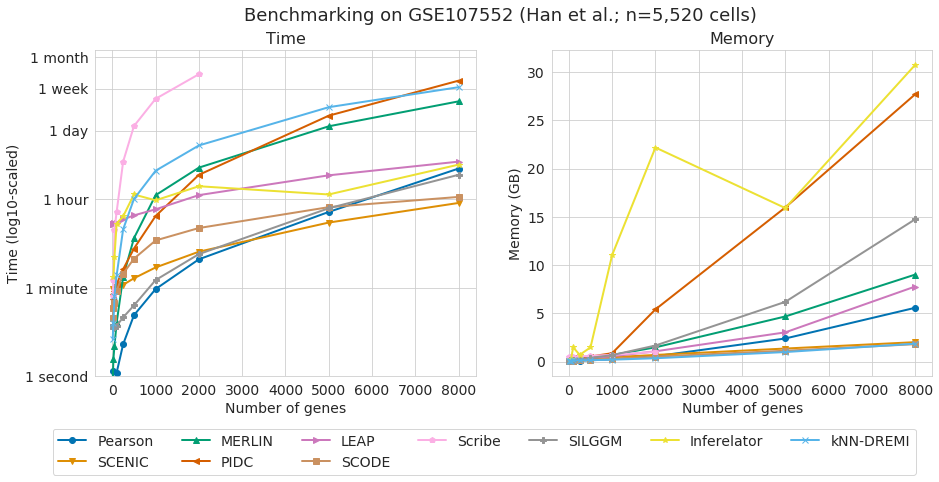

In [20]:
fig, axes = plt.subplots(1, 2, figsize=(15, 6))

RESOURCES = 'log_hours mem_GB'.split()
resource_titles = {'log_hours': 'Time (log10-scaled)', 'mem_GB': 'Memory (GB)'}

for resource, ax in zip(RESOURCES, axes):
    ymax = resources[resource].max()
    
    for i, algorithm in enumerate(ALGORITHMS):
        data = resources.loc[resources.algorithm == algorithm]
        ax.plot(data.n_genes, data[resource], linewidth=2,
                marker=MARKERS[i], linestyle='-', label=algorithm)

    if resource == 'log_hours':
        ax.set_ylim(-3, 3)
        ax.set_yticks(np.log10(human_ticks))
        units = 'second minute hour day week month'.split()
        ax.set_yticklabels(['1 ' + unit for unit in units])

    ax.set_ylabel(resource_titles[resource])
    ax.set_xlabel('Number of genes')
    ax.set_title(resource_titles[resource].split()[0])
    
l = ax.legend(frameon=True, title=None, ncol=7,
              bbox_to_anchor=(0.485, 0.02), loc='upper center', 
              bbox_transform=fig.transFigure)
l.get_frame().set_linewidth(1)
l.get_title().set_fontsize(plt.rcParams['legend.fontsize'])

fig.suptitle('Benchmarking on GSE107552 (Han et al.; n=5,520 cells)')

plt.savefig(os.path.join(OUTDIR, 'fig2b_runtime_and_memory.pdf'), bbox_inches='tight')